In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import unicodedata
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from google.colab import files
import pickle



In [ ]:
class Lang:
    def __init__(self,name):
      #Here we are maintaining three dictionaries, one to convert word into index,another index into word and count.
      #Also we are maintaining global count of distinct words.
      self.name=name
      self.word2index={"<start>":1,"<end>":2}
      self.word2count={"<start>":0,"<end>":0}
      self.index2word={1:"<start>",2:"<end>"}
      self.n_count=3
    def addsentence(self,sent):
      s=sent.split(" ")
      for i in s:
        self.addword(i)

    #preprocessing the data. Seperating the words into dictionary
    def addword(self,word):
      if word not in self.word2index:
        self.word2index[word]=self.n_count
        self.word2count[word]=1
        self.index2word[self.n_count]=word
        self.n_count+=1
      else:
        self.word2count[word]+=1
    

In [ ]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def clean(w):
    # s=unicode_to_ascii(s)
    w = re.sub(r"([?.!,¿])", r" \1 ", w) # creating a space between words and punctation following it
    w = re.sub(r'[" "]+', " ", w)
    w = w.rstrip().strip()
    w = "<start> " + w + " <end>"     # so that the model know when to start and stop predicting
    return w
def read(source,target,links,limit,reverse=False):
  MAX_len=30
  with open(links[source]) as f1,open(links[target]) as f2:
    pairs=[]
    count=0
    for x,y in zip(f1,f2):
      if count>limit:
        break
      x,y=x.strip(),y.strip()
      count+=1
#Because all the other tensors will be padded according to max word length we have to keep an upper cap on max word to limit.
      if len(x)<MAX_len and len(y)<MAX_len:
        pairs.append([clean(x),clean(y)] )
    input_lang=Lang(source)
    output_lang=Lang(target)
    if reverse:
      pairs=[list(reversed(l)) for l in pairs]
      input_lang,output_lang=output_lang,input_lang
    for pair in pairs:
      input_lang.addsentence(pair[0])
      output_lang.addsentence(pair[1])
    print(input_lang.n_count)
    return pairs,input_lang,output_lang

def tokenize(pairs,input_lang,output_lang):
  input_tensor=list([])
  output_tensor=list([])
  print(len(pairs))
  input_tensor=[[input_lang.word2index[word] for word in i[0].split(" ")] for i in pairs]
  output_tensor=[[output_lang.word2index[word] for word in i[1].split(" ")] for i in pairs]
  # input_tensor=tf.keras.preprocessing.sequence.pad_sequences(input_tensor,padding='post')
  # output_tensor=tf.keras.preprocessing.sequence.pad_sequences(output_tensor,padding='post')
  return input_tensor,output_tensor
def pad(tensor):
  tensor=tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
  return tensor

In [ ]:
links={}
links["nepali"]="/content/drive/My Drive/train.ne"
links["english"]="/content/drive/My Drive/train.en"
pairs,input_lang,output_lang=read("nepali","english",links,1000000,reverse=False)

12313


In [ ]:
input_tensor,output_tensor=tokenize(pairs,input_lang,output_lang)

17502


In [ ]:
input_tensor=pad(input_tensor)
output_tensor=pad(output_tensor)
print(input_tensor[0])
print(input_tensor.shape)
print(output_tensor.shape)

[1 3 4 5 4 6 4 2 0 0 0 0 0 0 0]
(17502, 15)
(17502, 15)


In [ ]:
with open('langs_nep.pkl', 'wb') as f:
  pickle.dump(input_lang, f, pickle.HIGHEST_PROTOCOL)
  pickle.dump(output_lang, f, pickle.HIGHEST_PROTOCOL)

files.download('langs_nep.pkl') 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(input_tensor[:6])
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index2word[t]))
convert(input_lang,input_tensor[3])

[[ 1  3  4  5  4  6  4  2  0  0  0  0  0  0  0]
 [ 1  7  4  8  4  9  4  2  0  0  0  0  0  0  0]
 [ 1 10  4 11  4 12  2  0  0  0  0  0  0  0  0]
 [ 1 13 14 15 16  2  0  0  0  0  0  0  0  0  0]
 [ 1 17  4 18 19  2  0  0  0  0  0  0  0  0  0]
 [ 1 20  4 21  4 22  2  0  0  0  0  0  0  0  0]]
1 ----> <start>
13 ----> एतानका
14 ----> छोरा
15 ----> अजर्याह
16 ----> थिए।
2 ----> <end>


In [ ]:
input_tensor_train, input_tensor_val, output_tensor_train, output_tensor_val = train_test_split(input_tensor, output_tensor, test_size=0.05)
print(len(input_tensor_train), len(output_tensor_train), len(input_tensor_val), len(output_tensor_val))

16626 16626 876 876


In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
iterations=int(BUFFER_SIZE/BATCH_SIZE)
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 512
vocab_inp_size = len(input_lang.word2index)+1
vocab_tar_size = len(output_lang.word2index)+1

In [ ]:
class Encoder(tf.keras.Model):
  
  def __init__(self,vocab_l,embeding_dim,enc_units,batch_size):
    super(Encoder, self).__init__()
    self.batch_size=batch_size
    self.vocab_l=vocab_l
    self.embeding_dim=embeding_dim
    self.enc_units=enc_units
    self.embedding=tf.keras.layers.Embedding(vocab_l,embedding_dim)
    self.gru=tf.keras.layers.GRU(self.enc_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')

  def call(self,x,hidden):
    x=self.embedding(x)
    output,state=self.gru(x,initial_state=hidden)
    return output,state
  
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_size,self.enc_units))

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train,output_tensor_train))
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val,output_tensor_val))
val_dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
print(dataset)
example_input_batch,example_target_batch=next(iter(dataset))



encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))



<BatchDataset shapes: ((64, 15), (64, 15)), types: (tf.int32, tf.int32)>
Encoder output shape: (batch size, sequence length, units) (64, 15, 512)
Encoder Hidden state shape: (batch size, units) (64, 512)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 512)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    x = self.embedding(x)

    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 11658)


In [ ]:
with open('tensors_nep.pkl', 'wb') as f:
  pickle.dump(example_input_batch,f, pickle.HIGHEST_PROTOCOL)
  pickle.dump(example_target_batch,f, pickle.HIGHEST_PROTOCOL)
files.download("tensors_nep.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([output_lang.word2index['<start>']] * BATCH_SIZE, 1)
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)
      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
checkpoint_dir = '/content/drive/My Drive/training_nepali'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
EPOCHS = 15
for epoch in range(EPOCHS):
  start = time.time()
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  counter=0

  for (batch, (inp, output)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp,output, enc_hidden)
    total_loss += batch_loss

    if batch % 500 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
      

  if epoch%2==0:
    checkpoint.save(file_prefix = checkpoint_prefix+"{epoch}".format(epoch=counter))
  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  counter+=1
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.9262
Epoch 1 Loss 2.0833
Time taken for 1 epoch 39.64185905456543 sec

Epoch 2 Batch 0 Loss 1.9055
Epoch 2 Loss 1.8501
Time taken for 1 epoch 23.51036310195923 sec

Epoch 3 Batch 0 Loss 1.7745
Epoch 3 Loss 1.7450
Time taken for 1 epoch 24.427156686782837 sec

Epoch 4 Batch 0 Loss 1.6678
Epoch 4 Loss 1.6523
Time taken for 1 epoch 23.787142515182495 sec

Epoch 5 Batch 0 Loss 1.5382
Epoch 5 Loss 1.5261
Time taken for 1 epoch 24.347450733184814 sec

Epoch 6 Batch 0 Loss 1.4019
Epoch 6 Loss 1.3940
Time taken for 1 epoch 23.787771701812744 sec

Epoch 7 Batch 0 Loss 1.2815
Epoch 7 Loss 1.2726
Time taken for 1 epoch 24.365843534469604 sec

Epoch 8 Batch 0 Loss 1.1431
Epoch 8 Loss 1.1515
Time taken for 1 epoch 23.81008005142212 sec

Epoch 9 Batch 0 Loss 1.0264
Epoch 9 Loss 1.0353
Time taken for 1 epoch 24.466030836105347 sec

Epoch 10 Batch 0 Loss 0.9108
Epoch 10 Loss 0.9290
Time taken for 1 epoch 23.762628316879272 sec

Epoch 11 Batch 0 Loss 0.8053
Epoch 11 Loss 0.8340
T

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((30 , 30))
  sentence =clean(sentence)
  inputs=[]
  for i in sentence.split(' '):
    if i in input_lang.word2index:
      inputs.append(input_lang.word2index[i])
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=30,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([output_lang.word2index['<start>']], 0)

  for t in range(30):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += output_lang.index2word[predicted_id] + ' '

    if output_lang.index2word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
print(output_lang.word2index)

{'<start>': 1, '<end>': 2, 'Shem': 3, ',': 4, 'Arpachshad': 5, 'Shelah': 6, 'Eber': 7, 'Peleg': 8, 'Reu': 9, 'Serug': 10, 'Nahor': 11, 'Terah': 12, 'The': 13, 'sons': 14, 'of': 15, 'Ethan:': 16, 'Azariah': 17, '.': 18, 'Benaiah': 19, 'Bedeiah': 20, 'Cheluhi': 21, 'Vaniah': 22, 'Meremoth': 23, 'Eliashib': 24, 'Machnadebai': 25, 'Shashai': 26, 'Sharai': 27, 'Shallum': 28, 'Amariah': 29, 'Joseph': 30, 'Seraiah': 31, 'Jeremiah': 32, 'Pashhur': 33, 'Malchijah': 34, 'Hattush': 35, 'Shebaniah': 36, 'Malluch': 37, 'Harim': 38, 'Obadiah': 39, 'Daniel': 40, 'Ginnethon': 41, 'Baruch': 42, 'Meshullam': 43, 'Abijah': 44, 'Mijamin': 45, 'Mica': 46, 'Rehob': 47, 'Hashabiah': 48, 'Zaccur': 49, 'Sherebiah': 50, 'Hodiah': 51, 'Bani': 52, 'Beninu': 53, 'Bunni': 54, 'Azgad': 55, 'Bebai': 56, 'Adonijah': 57, 'Bigvai': 58, 'Adin': 59, 'Ater': 60, 'Hezekiah': 61, 'Azzur': 62, 'Hashum': 63, 'Bezai': 64, 'Hariph': 65, 'Anathoth': 66, 'Nobai': 67, 'Magpiash': 68, 'Hezir': 69, 'Meshezabel': 70, 'Zadok': 71, 'Jad

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))


  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))
def translate_acc(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  return result

Input: <start> खोला बगेको स्थानलाई पुरेर फुटबल मैदान बनाइएको हो <end>
Predicted translation: Expected all are too big spoon ghee or oil <end> 


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2326 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2379 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2366 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2348 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2327 missing from current font.
  font.set_text(s

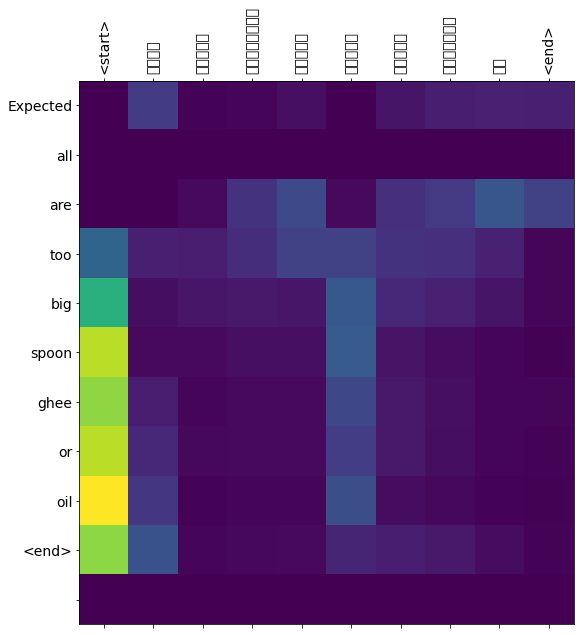

In [ ]:
translate("खोला बगेको स्थानलाई पुरेर फुटबल मैदान बनाइएको हो ")